# Avaliação em holdouts - Palco 2010

* Exp1: 10 last examples of each user 
* Exp2: 10 last exaples, overall
* Exp3: 10 last examples, and allow seen items
* Exp4: 10 last exaples, overall, and allow seen items
* Exp5: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items
* Exp6: 10 last exaples, overall, and dont remove items that are in holdout from train data, and allow seen items
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket
* Exp8: 10 last exaples, overall, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket
* Exp9: 10 randomly selected examples from each user, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket
* Exp10: 


# Import stuff

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/../..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
# from flurs.recommender import BPRMFRecommender
from eval_implicit import EvaluateHoldoutsFlurs # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'flurs'

___
# BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [ ]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Read Data

In [ ]:
# importa dataset 'palco playlists'
data = pd.read_csv('../output/palco_2010_dump/sampled_palco2010.csv')
user_col = 'user_id'
item_col = 'track_id'

In [ ]:
data.shape, data.user_id.nunique(), data.track_id.nunique()

((435621, 7), 2921, 22103)

In [ ]:
data[['user_id', 'track_id']].duplicated().sum()

210466

In [ ]:
data.shape

(435621, 7)

In [ ]:
data.head()

,user_id,track_id,timestamp,date2,year,month,date
0,4220,31313,2010-01-01 00:10:36,2010-01-01,2010,1,2010-01-01
1,4220,29567,2010-01-01 00:13:07,2010-01-01,2010,1,2010-01-01
2,4220,31313,2010-01-01 00:13:18,2010-01-01,2010,1,2010-01-01
3,6258,18106,2010-01-01 00:46:25,2010-01-01,2010,1,2010-01-01
4,42186,5066,2010-01-01 00:50:59,2010-01-01,2010,1,2010-01-01


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435621 entries, 0 to 435620
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    435621 non-null  int64 
 1   track_id   435621 non-null  int64 
 2   timestamp  435621 non-null  object
 3   date2      435621 non-null  object
 4   year       435621 non-null  int64 
 5   month      435621 non-null  int64 
 6   date       435621 non-null  object
dtypes: int64(4), object(3)
memory usage: 23.3+ MB


### Convert timestamp

In [ ]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 2.61 s, sys: 26.8 ms, total: 2.64 s
Wall time: 2.64 s


CPU times: user 83 ms, sys: 15.8 ms, total: 98.7 ms
Wall time: 217 ms


Text(0.5, 1.0, 'interactions per month')

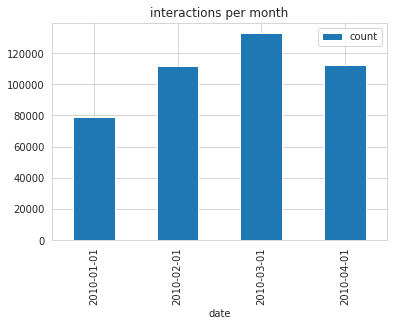

In [ ]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

# Hyperparameters

In [ ]:
# define hyperparameters
k, l2_reg, learn_rate = (200, 0.5, 0.5)

# EXPERIMENT 1

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETSLAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT  

In [13]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

Creating buckets. . .


In [14]:
# get frequent users - threshold = N
all_users = data[user_col].unique()
frequent_users_per_bucket = []
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users_per_bucket.append(list(b[user_col].value_counts()[ condition ].index))
frequent_users = []
for u in all_users:
    check_u = [u in fulist for fulist in frequent_users_per_bucket]
    if np.all( check_u ):
        frequent_users.append(u)

In [15]:
#CHANGE FREQUENT USERS BELOW!

In [16]:
print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)

print('Removing seen examples from buckets')

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b


Creating holdouts. . .
Removing seen examples from buckets


In [17]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [18]:
sum( [b.size for b in buckets] ), sum( [h.size for h in holdouts] )

(281977, 43140)

In [19]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [20]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [22]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.05115318298339844 register users time
register items
0.0 %
63.103663206100464 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 2h 43min 23s, sys: 5h 46min 46s, total: 8h 30min 10s
Wall time: 41min 55s


In [23]:
rm = eval.results_matrix
df_exp1 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 1

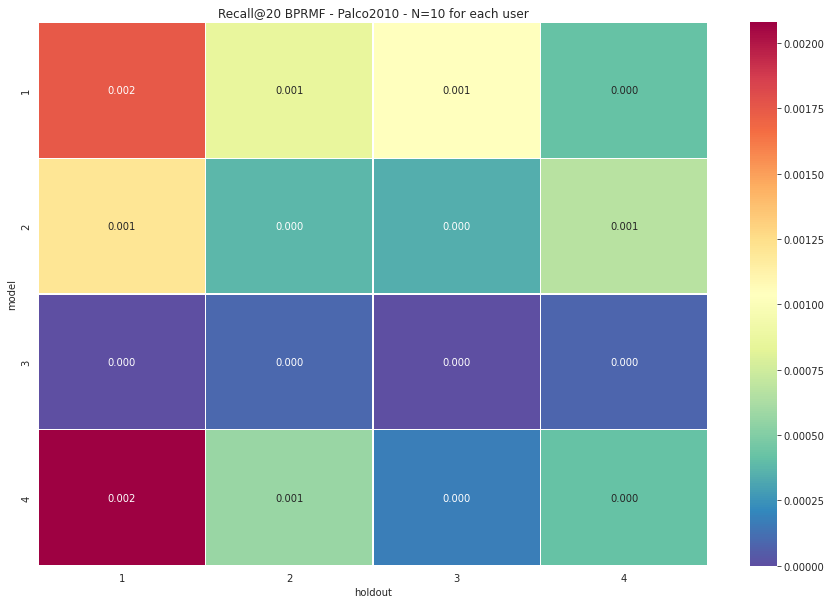

In [24]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp1,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 for each user',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [25]:
arecall = avg_recall(df_exp1)
arecall

0.000637643783477965

In [26]:
BWT, meanBWT = compute_BWT(df_exp1)
BWT, meanBWT

([-0.0005470459518599562, -0.0010175885134882639, 0.00023028057960574537],
 -0.0004447846285808249)

In [27]:
FWT = compute_FWT(df_exp1)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0005690394616136302

# EXPERIMENT 2

CODE TO GET LAST N ITEMS AS HOLDOUT
INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

In [28]:
# CODE TO GET LAST N ITEMS AS HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []
frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        interaction_idx = []
        tail = b.tail(N)
        for idx, example in tail.iterrows():
            user = example[user_col]
            if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
                if user not in frequent_users_seen:
                    frequent_users_seen.append(user)
                interaction_idx.append(idx)
        holdout = b.loc[interaction_idx].reset_index(drop=True)
        # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
        # print( holdout.shape)
        holdouts.append(holdout)
        buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
        # print(buckets[i].shape)

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b

Creating buckets. . .
Creating holdouts. . .


In [29]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [30]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

416781

In [31]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(77457, 1248, 10032),
 (108590, 1392, 12730),
 (124443, 1499, 12772),
 (106251, 1577, 14071)]

In [28]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(10, 2, 10), (10, 3, 4), (10, 7, 10), (10, 4, 10)]

In [32]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [33]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [34]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.047255754470825195 register users time
register items
0.0 %
46.632014751434326 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 13min 55s, sys: 1min 25s, total: 15min 21s
Wall time: 14min 49s


In [35]:
rm = eval.results_matrix
df_exp2 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 2

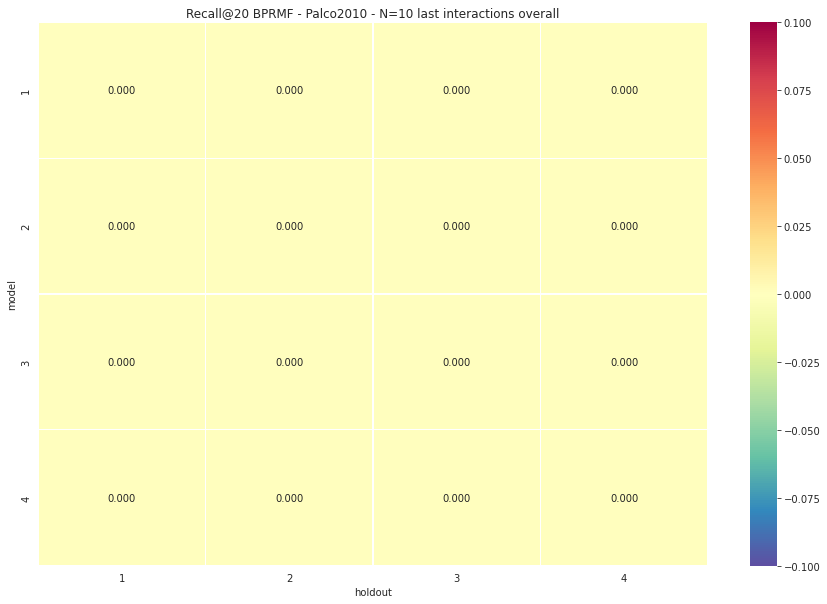

In [36]:
# result with N=10 last interactions
# items in holdout are removed from training
recall_heatmap(df_exp2,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 last interactions overall',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [37]:
arecall = avg_recall(df_exp2)
arecall

0.0

In [38]:
BWT, meanBWT = compute_BWT(df_exp2)
BWT, meanBWT

([0.0, 0.0, 0.0], 0.0)

In [39]:
FWT = compute_FWT(df_exp2)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0

# EXPERIMENT 3

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETSLAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED

In [40]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)

print('Removing seen examples from buckets')

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b


Creating buckets. . .
Creating holdouts. . .
Removing seen examples from buckets


In [41]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [42]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

325117

In [43]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [44]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [45]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.045519351959228516 register users time
register items
0.0 %
40.17414379119873 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 2h 19min 1s, sys: 4h 40min 46s, total: 6h 59min 47s
Wall time: 35min 21s


In [46]:
rm = eval.results_matrix
df_exp3 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 3

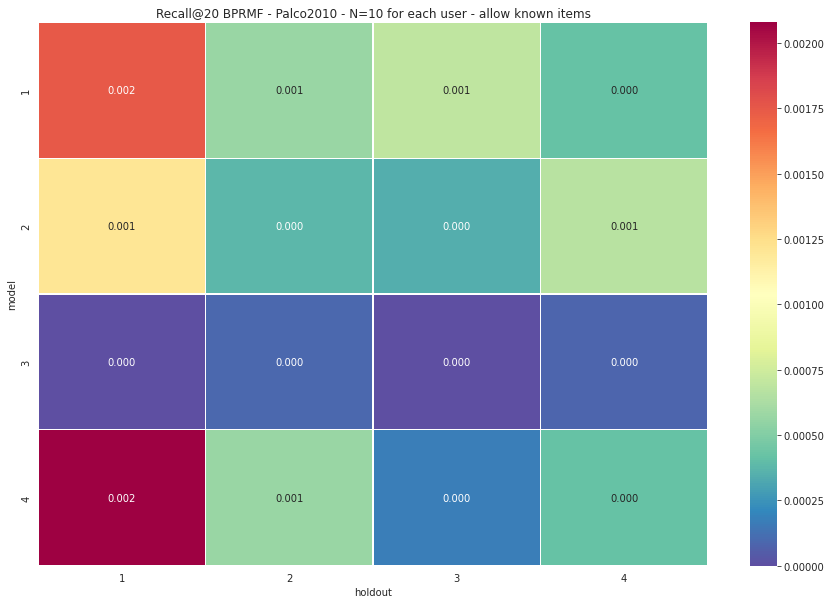

In [47]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp3,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 for each user - allow known items',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [48]:
arecall = avg_recall(df_exp3)
arecall

0.000637643783477965

In [49]:
BWT, meanBWT = compute_BWT(df_exp3)
BWT, meanBWT

([-0.0005470459518599562, -0.0010175885134882639, 0.00023028057960574537],
 -0.0004447846285808249)

In [50]:
FWT = compute_FWT(df_exp3)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.00046398084910346865

# EXPERIMENT 4

CODE TO GET LAST N ITEMS AS HOLDOUT  
* INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS
* RECOMENDING SEEN ITEMS IS ALLOWED

In [51]:
# CODE TO GET LAST N ITEMS AS HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []
frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        interaction_idx = []
        tail = b.tail(N)
        for idx, example in tail.iterrows():
            user = example[user_col]
            if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
                if user not in frequent_users_seen:
                    frequent_users_seen.append(user)
                interaction_idx.append(idx)
        holdout = b.loc[interaction_idx].reset_index(drop=True)
        # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
        # print( holdout.shape)
        holdouts.append(holdout)
        buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
        # print(buckets[i].shape)

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b

Creating buckets. . .
Creating holdouts. . .


In [52]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [53]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

416781

In [54]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(77457, 1248, 10032),
 (108590, 1392, 12730),
 (124443, 1499, 12772),
 (106251, 1577, 14071)]

In [55]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(10, 2, 10), (10, 3, 4), (10, 7, 10), (10, 4, 10)]

In [56]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [57]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [58]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.04257941246032715 register users time
register items
0.0 %
39.33890962600708 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 13min 5s, sys: 24.1 s, total: 13min 29s
Wall time: 13min 1s


In [59]:
rm = eval.results_matrix
df_exp4 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 4

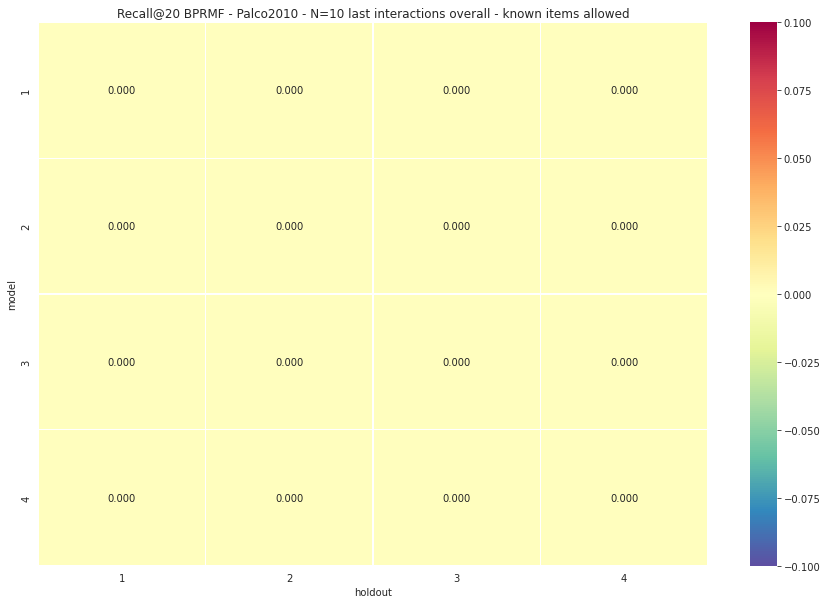

In [60]:
# result with N=10 last interactions
# items in holdout are removed from training
recall_heatmap(df_exp4,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 last interactions overall - known items allowed',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [61]:
arecall = avg_recall(df_exp4)
arecall

0.0

In [62]:
BWT, meanBWT = compute_BWT(df_exp4)
BWT, meanBWT

([0.0, 0.0, 0.0], 0.0)

In [63]:
FWT = compute_FWT(df_exp4)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0

# EXPERIMENT 5

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* LAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS

In [64]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .


In [65]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [66]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

435621

In [67]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [68]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [69]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.04330730438232422 register users time
register items
0.0 %
39.526668071746826 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 2h 28min 29s, sys: 5h 2min 8s, total: 7h 30min 38s
Wall time: 40min 6s


In [70]:
rm = eval.results_matrix
df_exp5 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 5

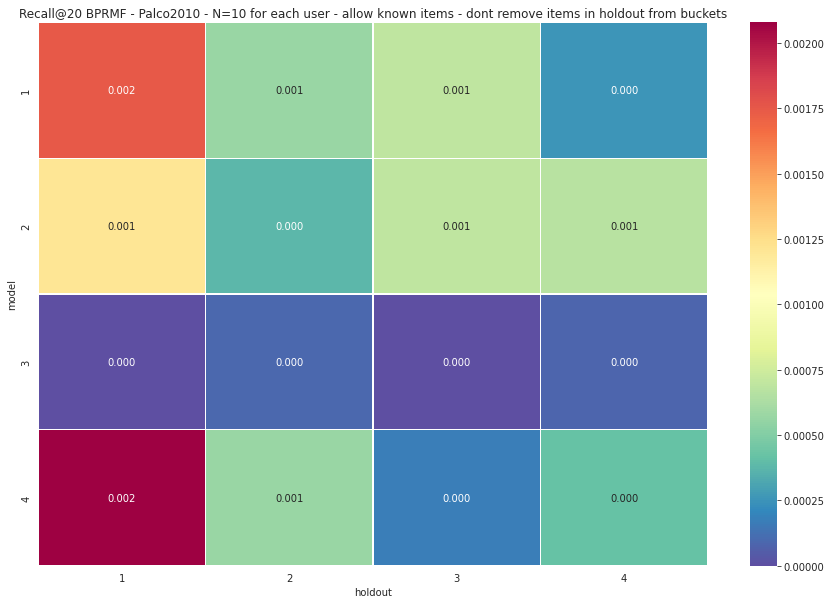

In [71]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp5,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 for each user - allow known items - dont remove items in holdout from buckets',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [72]:
arecall = avg_recall(df_exp5)
arecall

0.000637643783477965

In [73]:
BWT, meanBWT = compute_BWT(df_exp5)
BWT, meanBWT

([-0.0005470459518599562, -0.0010175885134882639, 0.00023028057960574537],
 -0.0004447846285808249)

In [74]:
FWT = compute_FWT(df_exp5)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0004935663683366003

# EXPERIMENT 6

CODE TO GET LAST N ITEMS AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS FROM HOLDOUTS FROM BUCKETS

In [75]:
# CODE TO GET LAST N ITEMS AS HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []
frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        interaction_idx = []
        tail = b.tail(N)
        for idx, example in tail.iterrows():
            user = example[user_col]
            if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
                if user not in frequent_users_seen:
                    frequent_users_seen.append(user)
                interaction_idx.append(idx)
        holdout = b.loc[interaction_idx].reset_index(drop=True)
        # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
        # print( holdout.shape)
        holdouts.append(holdout)
        buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
        # print(buckets[i].shape)

Creating buckets. . .
Creating holdouts. . .


In [76]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [77]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

435621

In [78]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(79002, 1248, 10034),
 (111330, 1392, 12730),
 (132830, 1499, 12772),
 (112419, 1577, 14071)]

In [79]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(10, 2, 10), (10, 3, 4), (10, 7, 10), (10, 4, 10)]

In [80]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [81]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [82]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.04960918426513672 register users time
register items
0.0 %
39.763230085372925 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 13min 44s, sys: 27.4 s, total: 14min 11s
Wall time: 13min 38s


In [83]:
rm = eval.results_matrix
df_exp6 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 6

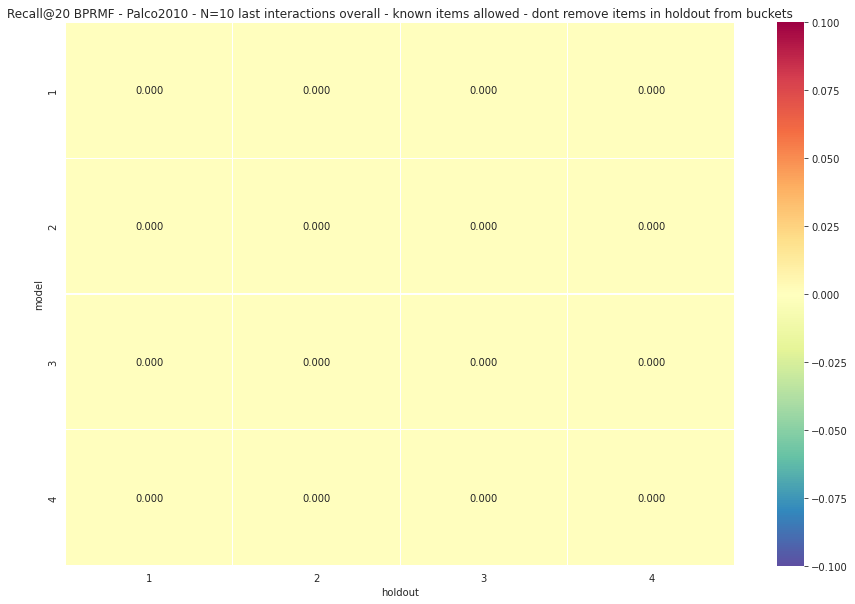

In [84]:
# result with N=10 last interactions
# items in holdout are removed from training
recall_heatmap(df_exp6,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 last interactions overall - known items allowed - dont remove items in holdout from buckets',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [85]:
arecall = avg_recall(df_exp6)
arecall

0.0

In [86]:
BWT, meanBWT = compute_BWT(df_exp6)
BWT, meanBWT

([0.0, 0.0, 0.0], 0.0)

In [87]:
FWT = compute_FWT(df_exp6)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0

# EXPERIMENT 7

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* LAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [88]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        # buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .


In [89]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [90]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

478761

In [91]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [92]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [93]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.0400393009185791 register users time
register items
0.0 %
39.649991273880005 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 2h 25min 43s, sys: 4h 49min 22s, total: 7h 15min 6s
Wall time: 40min 26s


In [94]:
rm = eval.results_matrix
df_exp7 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 7

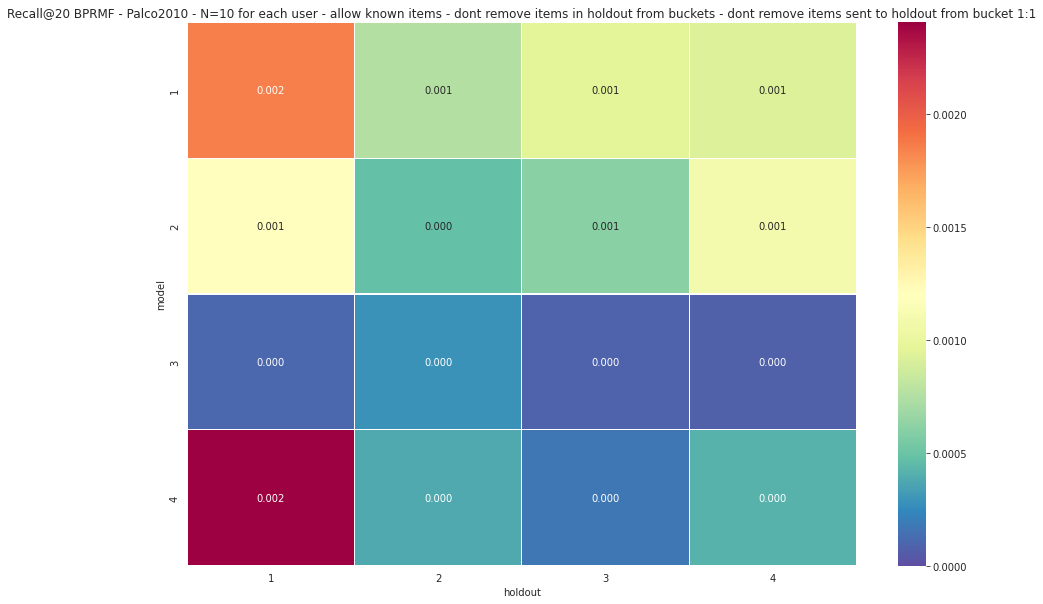

In [95]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp7,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 for each user - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [96]:
arecall = avg_recall(df_exp7)
arecall

0.0007103228520336206

In [97]:
BWT, meanBWT = compute_BWT(df_exp7)
BWT, meanBWT

([-0.0006564551422319474, -0.000970150183317486, 0.00017953323834249188],
 -0.0004823573624023138)

In [98]:
FWT = compute_FWT(df_exp7)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0007362280231441137

# EXPERIMENT 8

CODE TO GET LAST N ITEMS AS HOLDOUT  
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS FROM HOLDOUTS FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [99]:
# CODE TO GET LAST N ITEMS AS HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []
frequent_users_seen = [] # frequent users must have been seen at least once before being sent to holdouts. 

# Imagine if the first frequent user interaction is the single interaction by this user in an interval, then this single interaction cant be sent to the holdout.
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        interaction_idx = []
        tail = b.tail(N)
        for idx, example in tail.iterrows():
            user = example[user_col]
            if (user in frequent_users_seen) or ((b.iloc[:b.shape[0]-N])[user_col] == user).sum(): # if user appeared before
                if user not in frequent_users_seen:
                    frequent_users_seen.append(user)
                interaction_idx.append(idx)
        holdout = b.loc[interaction_idx].reset_index(drop=True)
        # print(b.shape[0], b.iloc[:b.shape[0]-N].tail(10).index,  interaction_idx ) 
        # print( holdout.shape)
        holdouts.append(holdout)
        # buckets[i] = b.iloc[:b.shape[0]-N].reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)
        # print(buckets[i].shape)

Creating buckets. . .
Creating holdouts. . .


In [100]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [101]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

435661

In [102]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(79012, 1248, 10035),
 (111340, 1392, 12731),
 (132840, 1499, 12773),
 (112429, 1577, 14074)]

In [103]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(10, 2, 10), (10, 3, 4), (10, 7, 10), (10, 4, 10)]

In [104]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [105]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [106]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.04395747184753418 register users time
register items
0.0 %
39.32913374900818 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 13min 42s, sys: 27.2 s, total: 14min 9s
Wall time: 13min 37s


In [107]:
rm = eval.results_matrix
df_exp8 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 8

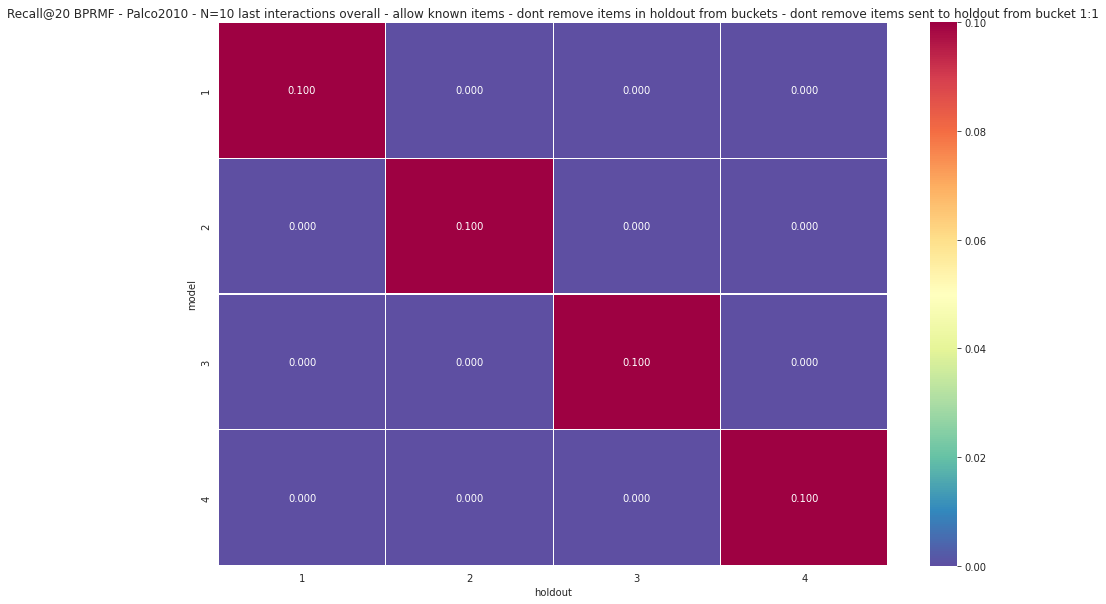

In [108]:
# result with N=10 last interactions
# items in holdout are removed from training
recall_heatmap(df_exp8,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 last interactions overall - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [109]:
arecall = avg_recall(df_exp8)
arecall

0.1

In [110]:
BWT, meanBWT = compute_BWT(df_exp8)
BWT, meanBWT

([-0.1, -0.1, -0.10000000000000002], -0.10000000000000002)

In [111]:
FWT = compute_FWT(df_exp8)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0

# EXPERIMENT 9

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* 10 INTERACTIONS FROM EACH USER AS HOLDOUT - **RANDOMLY SAMPLED**
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [112]:
# CODE TO GET N INTERACTIONS FROM EACH USER AS HOLDOUT

np.random.seed(42)
N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            all_idx = list( b[b[user_col] == u].index )
            print( len(all_idx) )
            sample_idx = np.random.choice(a=all_idx, size=N, replace=False)
            holdout_idx += list( sample_idx )
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        # buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .
2037
1041
850
714
690
649
627
578
573
566
546
543
537
523
499
495
485
478
456
449
446
435
431
426
419
413
400
399
388
379
376
371
367
363
360
355
350
336
333
332
325
324
318
316
315
314
314
313
304
302
300
299
297
296
290
289
282
282
279
274
270
259
258
258
258
255
251
249
246
245
242
241
241
240
240
239
238
237
236
235
235
231
230
228
225
224
222
220
218
215
212
205
198
197
195
195
190
189
188
187
187
186
184
183
181
181
179
178
177
176
175
175
174
174
170
170
169
169
168
168
167
166
164
163
162
162
161
161
161
161
160
160
157
153
153
151
150
149
148
147
147
146
143
143
141
141
139
138
137
135
132
131
131
130
130
129
129
129
129
129
127
126
125
125
125
124
123
122
121
121
121
121
121
120
120
119
119
118
118
118
118
118
118
117
116
113
112
112
112
111
111
111
109
108
108
108
107
107
106
106
106
106
105
104
104
104
103
102
101
101
100
99
99
99
98
98
97
97
97
96
96
95
95
95
95
94
93
93
92
92
91
90
90
89
89
89
88
87
87
87
86
86
86
85
84
84
83
8

In [113]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [114]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

478761

In [115]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. 
# Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [116]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [117]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True)

register users
0.0 %
0.041370391845703125 register users time
register items
0.0 %
39.53474473953247 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0


/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: model 3 x holdout 0
Evaluating: model 3 x holdout 1
Evaluating: model 3 x holdout 2
Evaluating: model 3 x holdout 3
CPU times: user 2h 41min 37s, sys: 5h 35min 13s, total: 8h 16min 51s
Wall time: 44min 22s


In [118]:
rm = eval.results_matrix
df_exp9 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 9

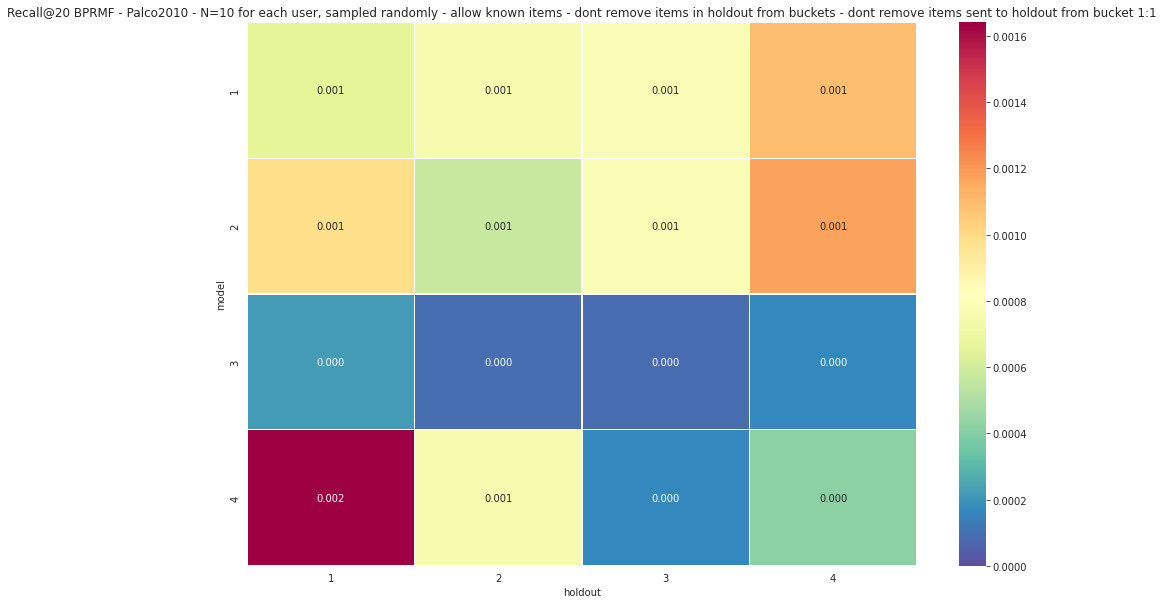

In [119]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp9,
    round_point=3,
    title='Recall@20 BPRMF - Palco2010 - N=10 for each user, sampled randomly - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [120]:
arecall = avg_recall(df_exp9)
arecall

0.0004331667435960337

In [121]:
BWT, meanBWT = compute_BWT(df_exp9)
BWT, meanBWT

([0.0003282275711159738, -0.0004560100315978724, 0.00042028881918003614],
 9.750211956604584e-05)

In [122]:
FWT = compute_FWT(df_exp9)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0007922975493566173

# Store exp results

In [123]:
allresults = [df_exp1, df_exp2, df_exp3, df_exp4, df_exp5, df_exp6, df_exp7, df_exp8, df_exp9]

In [125]:
for r in range( len(allresults )):
    allresults[r].to_csv(f'../output_p10_10_examples/BPRMF_result_exp_{r+1}')

# Read results

In [126]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

* Exp1: 10 last examples of each user 
* Exp3: 10 last examples, and allow seen items
* Exp5: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket
* Exp9: 10 randomly selected examples from each user, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

In [127]:
results_10_each_user = {}
for r in range( 9 ):
    if not (r+1)%2==0:
        results_10_each_user[r+1]=pd.read_csv(f'../output_p10_10_examples/BPRMF_result_exp_{r+1}', index_col=0)

results_10_each_user = {
    k: {
        'avg_recall': avg_recall( results_10_each_user[k]),
        'BWT': compute_BWT( results_10_each_user[k] )[-1],
        'FWT': compute_FWT( results_10_each_user[k] )
        }
    for k in results_10_each_user.keys()
}

results_10_each_user = pd.DataFrame( results_10_each_user )

results_10_each_user

,1,3,5,7,9
avg_recall,0.000638,0.000638,0.000638,0.000710,0.000433
BWT,-0.000445,-0.000445,-0.000445,-0.000482,0.000098
FWT,0.000569,0.000464,0.000494,0.000736,0.000792


* Exp2: 10 last exaples, overall
* Exp4: 10 last exaples, overall, and allow seen items
* Exp6: 10 last exaples, overall, and dont remove items that are in holdout from train data, and allow seen items
* Exp8: 10 last exaples, overall, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

In [128]:
results_last_10 = {}
for r in range( 9 ):
    if (r+1)%2==0:
        results_last_10[r+1]=pd.read_csv(f'../output_p10_10_examples/BPRMF_result_exp_{r+1}', index_col=0)

results_last_10 = {
    k: {
        'avg_recall': avg_recall( results_last_10[k]),
        'BWT': compute_BWT( results_last_10[k] )[-1],
        'FWT': compute_FWT( results_last_10[k] )
        }
    for k in results_last_10.keys()
}

results_last_10 = pd.DataFrame( results_last_10 )

results_last_10

,2,4,6,8
avg_recall,0.0,0.0,0.0,0.1
BWT,0.0,0.0,0.0,-0.1
FWT,0.0,0.0,0.0,0.0


# ORIGINAL RESULT - DONT CONTINUE

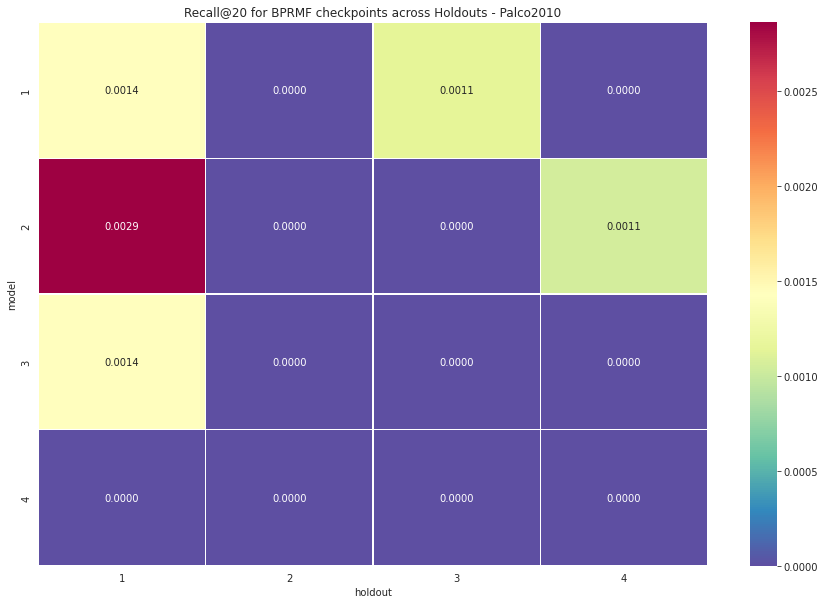

In [ ]:
recall_heatmap(df,
               round_point=4,
    title='Recall@20 for BPRMF checkpoints across Holdouts - Palco2010',
    filepath='images/heatmaps/palco_2010_dump/sample_palco2010 month_bucket BPRMF heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
arecall = avg_recall(df)
arecall

0.000357653791130186

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.001430615164520744, 0.0, -0.0004768717215069146], 0.00031791448100460976)

In [ ]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0003666884948011183